<a href="https://colab.research.google.com/github/sbbwoy/ESAA/blob/main/220312_ch3_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CH3. 분류**



#3.1 MNIST

* DESCR: 데이터셋 설명
* data: 샘플이 (1, 1)로 구성된 배열
* target: 레이블 배열

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
import numpy as np
X, y = mnist['data'], mnist['target']
y = y.astype(np.int8)       #하단 오류 발생 방지 코드

X.shape, y.shape

((70000, 784), (70000,))

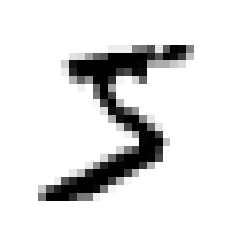

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.to_numpy()[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [ ]:
y[0]

5

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#3.2 이진 분류기 훈련

확률적 경사 하강법Stochasti Gradient Descent(SGD)

* 매우 큰 dataset을 효율적으로 처리하는 장점
* train 샘플을 독립적으로 처리
* train 시 random

In [6]:
y_train_5 = (y_train == 5)    
y_test_5 = (y_test == 5)

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([ True])

#3.3 성능 측정

##3.3.1 교차 검증을 사용한 정확도 측정

In [14]:
for train_index, test_index in skfolds.split(X_train, y_train_5):

<generator object _BaseKFold.split at 0x7f90faabd7d0>


In [17]:
#다음 코드는 cross_val_score() 함수와 거의 같은 작업 수행 후 동일한 결과를 출력함
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    if '\n' in train_index: train_index.replace('\n            ', '', inplace=True)
    if '\n' in test_index: test_index.replace('\n            ', '', inplace=True)
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[(train_index)]      #왜 오류가... 나냐? 누락값 때문?
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


KeyError: ignored

In [ ]:
from sklearn.model_selection import cross_val_score
# 훈련 세트를 3개의 fold로 나누고 각 fold에 대해 예측-평가 하기 위해 나머지 폴드로 훈련시킨 모델을 사용
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):      #5가 아닌 것들을 분류
    def fit(self, X, y=None): return self
    def predict(self, X): return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

**불균형한 데이터셋을 다룰 경우** 정확도accuracy를 성능 측정 지표로 선호하지 않음

##3.3.2 오차 행렬confusion matrix

* cross_val_predict()는 k-겹 교차 검증을 수행하나 평가 점수를 반환하지 않고 **각 테스트 fold에서 얻은 예측을 반환함**

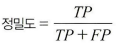
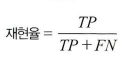

* TP: true positive

* FP: false positive

* FN: false negative

* TN: true negative

--> FP와 FN 중 어떤 걸 더 중점으로 둘지 가설에 따라 달라지나, 리스크를 줄이는 쪽으로!
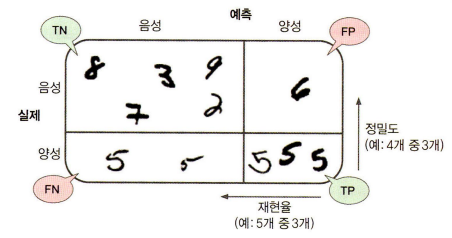



In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)
#오차 행렬의 행은 실제 클래스, 열은 예측한 클래스
#각각 true negative, false positive / false negative, true positive

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
y_train_perfect_predictions = y_train_5     # 완벽한 분류기일 경ㅇ우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

##3.3.3 정밀도와 재현율

F1 score: 정밀도와 재현율의 조화 평균harmonic mean

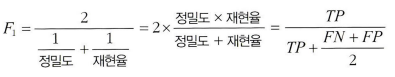

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)   

(0.8370879772350012, 0.6511713705958311)

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

##3.3.4 정밀도/재현율 트레이드오프
: 정밀도와 재현율은 반비례 관계

분류기는 결정 함수(decision function)을 이용하여 각 샘플의 점수를 계산한 후 결정 임곗값(decision threshold)보다 크면 양성 클래스로, 작으면 음성 클래스로 분류

SGDClassifier의 결정 임곗값은 0임

임곗값을 높이면 재현율↓

적절한 임곗값 찾기: 재현율 vs. 정밀도 그래프에서 하강점 직전 지점 선택

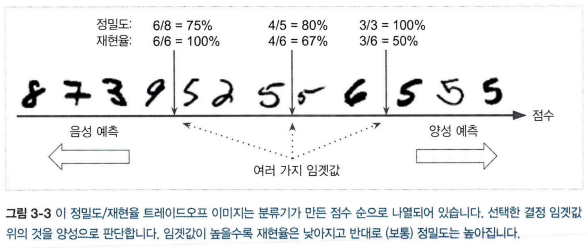

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([2164.22030239])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

--> 적절한 임곗값을 정하기 위해선 cross_val_predict()로 train set에 있는 모든 샘플의 score를 구해야 함

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

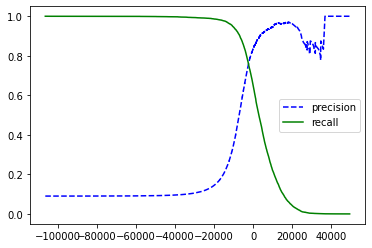

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recall')
    plt.legend()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

No handles with labels found to put in legend.


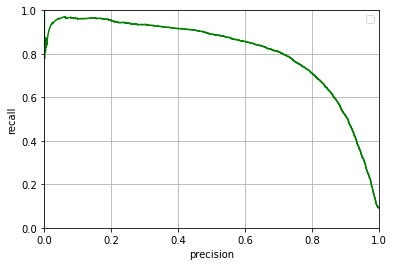

In [ ]:
def plot_precision_recall_vs_threshold_minor(precisions, recalls, thresholds):
    plt.plot(recalls[:-1], precisions[:-1], 'g-')
    plt.xlabel('precision')
    plt.ylabel('recall')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid()
    plt.legend()

plot_precision_recall_vs_threshold_minor(precisions, recalls, thresholds)
plt.show()
#정밀도에 대한 재현율 그래프

정밀도 80 근처에서 급격하게 떨어지므로 정밀도/재현율 트레드오프로 선택하는 것이 좋음

##3.3.5 ROC 곡선
수신기 조작 특성receiver operating characteristic(ROC) = 진짜 양성 비율 / 거짓 양성 비율

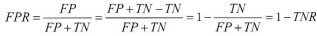

* 재현율(TPR)이 높을수록 거짓 양성(FPR)이 늘어남

* 점선은 완전한 랜덤 분류기의 ROC 곡선

* 좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 함

* 곡선 아래 면적(AUC)를 측정하면 분류기를 비교할 수 있음

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

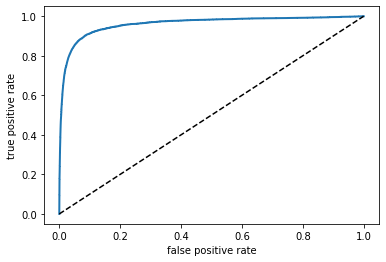

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [ ]:
y_scores_forest = y_probas_forest[:, 1]     # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

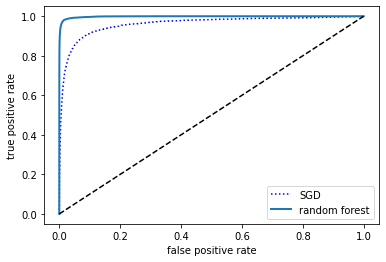

In [ ]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'random forest')
plt.legend(loc='lower right')
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

--> RandomForestClassifier이 SGDClassifier보다 성능이 나음

#3.4 다중 분류

* SGD
* RF
* naive Bayes

---------------------------------------

* Logistic Regression
* SVM(support Vector Machine

--> 이진 분류만 가능

---------------------------------------

OvR/OvA(일대다) 방식: 각 샘플에 대해 총 10번 각기 다른 이진 분류기를 실행한 후, 각 분류기의 결정 점수 중에서 가장 높은 점수를 받은 클래스 선택

OvO(일대일) 방식: 조합 가능한 모든 일대일 분류 방식을 진행하여 가장 많은 결투(duell)를 이긴 숫자를 선택

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])
#내부에서는 사이킷런이 OvO 전략으로 10개의 이진 분류기를 훈련시킨 후 각각의 결정 점수를 얻어 가장 높은 클래스를 선택

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


array([5], dtype=int8)

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [ ]:
np.argmax(some_digit_scores), svm_clf.classes_, svm_clf.classes_[5]

(5, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8), 5)

In [ ]:
#sklearn에서 OvO나 OvR을 사용하려면 OneVsOneClassifier나 OneVsRestClassifier를 사용
#SVC 기반 OvR 전략을 사용하는 다중 분류기
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit]), len(ovr_clf.estimators_)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packa

(array([5], dtype=int8), 10)

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([3], dtype=int8)

In [ ]:
#SBD 분류기가 클래스마다 부여한 점수 확인
sgd_clf.decision_function([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

#3.5 에러 분석

에러 비율: 오차 행렬의 각 값 / 대응되는 클래스의 이미지 개수

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

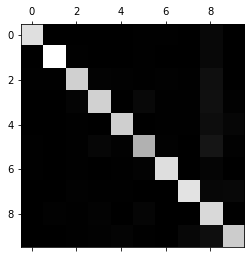

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

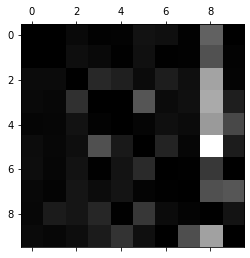

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()
#행은 실제 클래스, 열은 예측 클래스!!
#클래스 8의 열이 밝으므로 많은 이미지가 8로 잘못 분류됨을 암시함
#클래스 8의 행은 실제로 8에 해당하는 이미지가 8로 적절히 분류되었음을 알려줌

In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [np.array(instances.iloc[i]).reshape(size, size) for i in range(instances.shape[0])] #change done here
    
    if images_per_row == 0:
       images_per_row = 0.1
    
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

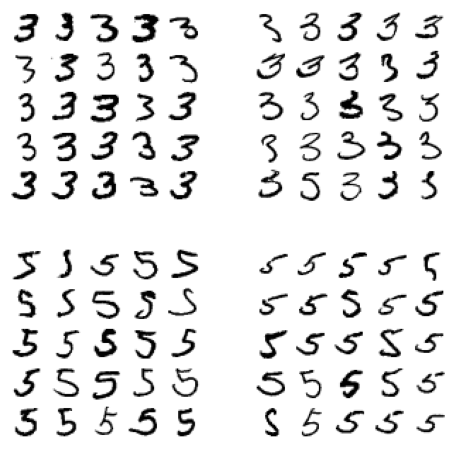

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

#3.6 다중 레이블

: 여러 개의 이진 꼬리표를 출력하는 분류 시스템multilabel classification

* 각 숫자 이미지에 두 개의 target label이 담긴 y_multilabel 배열을 만듦
* 첫 번째는 숫자가 큰 값(7, 8, 9)인지 
* 두 번째는 홀수인지
* 다중 타깃 배열을 사용해 훈련

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([[False,  True]])

In [ ]:
#다중 레이블 분류기 평가 - 모든 레이블에 대한 F1 score의 평균
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

#3.7 다중 출력 분류

다중 출력 다중 클래스 분류
* 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화

이미지 잡음 제거 시스템
* 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력
* 분류기의 출력이 다중 레이블(픽셀당 한 레이블)이고 각 레이블은 값을 여러 개 (0~255) 가짐

In [ ]:
#이미지 픽셀 강도에 잡음 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test